In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd ../gdrive/MyDrive/hw1ml/

In [ ]:
%ls


develop on local environment

In [ ]:
# Install useful stuff
! apt install --yes ssh screen nano htop ranger git > /dev/null
# SSH setting
! echo "root:carbonara" | chpasswd
! echo "PasswordAuthentication yes" > /etc/ssh/sshd_config
! echo "PermitUserEnvironment yes" >> /etc/ssh/sshd_config
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! service ssh restart > /dev/null
# Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip
# Run ngrok
authtoken = "20Apljvp3ViVnx3mzPGy8RN3VFt_4bzufXGF9Kkgm43PmRugS"
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
! sleep 3
# Get the address for SSH
import requests
from re import sub
r = requests.get('http://localhost:4040/api/tunnels')
str_ssh = r.json()['tunnels'][0]['public_url']
str_ssh = sub("tcp://", "", str_ssh)
str_ssh = sub(":", " -p ", str_ssh)
str_ssh = "ssh root@" + str_ssh
print(str_ssh)

use once you open the notebook

In [ ]:
%cd ../hw1ml

In [ ]:
!pip install shutup

In [ ]:

##At the top of the code
import shutup;
shutup.please()

read the dataset

In [96]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
import random
import warnings

#make everything reproducible
random.seed(100)
np.random.seed(100)


dataset=pd.read_csv("train_set.tsv", sep='\t', header=0)
dataset_numpy=dataset.to_numpy()
x=dataset_numpy[:,:-2]
y=dataset_numpy[:,-2:]



add new features

In [83]:
print(f"shape before {x.shape}")
for i in range(0, x.shape[1],7):
    distance_x=x[:,i+1]-x[:,i+5]
    distance_y=x[:,i+2]-x[:,i+6]
    cosine_north=np.cos(x[:,i])
    x=np.append(x, np.array([distance_x]).T, axis=1)
    x=np.append(x, np.array([distance_y]).T, axis=1)
    x=np.append(x, np.array([cosine_north]).T, axis=1)
print(f"shape after {x.shape}")  



shape before (1000, 35)
shape after (1000, 50)


use the minmax scaler

In [97]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x)
x=scaler.transform(x)

use the standard scaler

In [ ]:
scaler = StandardScaler()
scaler.fit(x)
x=scaler.transform(x)


if you want to normalize the data

In [ ]:
from sklearn.preprocessing import normalize
x=normalize(x)

trying to use pca features

In [ ]:

from sklearn.decomposition import PCA

pca = PCA(n_components=4)
x = pca.fit_transform(x)

trying to descretize


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer


trying to extract nonlinear features

In [ ]:
from sklearn.preprocessing import QuantileTransformer
x=QuantileTransformer().fit_transform(x)

split the dataset

In [98]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state=100)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(f"the classes and the number of occurrences in the train set are {np.unique(y_train[:,0], return_counts=True)}")
print(f"the classes and the number of occurrences in the test set are {np.unique(y_test[:,0], return_counts=True)}")

(750, 35) (750, 2) (250, 35) (250, 2)
the classes and the number of occurrences in the train set are (array([0., 1., 2., 3., 4.]), array([398, 252,  74,  24,   2], dtype=int64))
the classes and the number of occurrences in the test set are (array([0., 1., 2., 3., 4.]), array([140,  81,  22,   6,   1], dtype=int64))


compute class weights

In [113]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train[:,0]), 
    y=y_train[:,0]
    )
class_weight=dict(enumerate(class_weights))
sample_weight=np.array([class_weight[y_train[i,0]] for i in range(y_train.shape[0])])

to deal with unbalanced dataset one could try to undersple the overrapresented classes but here since the dataset is not big it doesn't work

In [ ]:
#if you want to undersample the data doenst work because i've not too much data 
from imblearn.under_sampling import RandomUnderSampler
over_sampler = RandomUnderSampler(random_state=42)
x_train, y_train = over_sampler.fit_resample(x_train, y_train[:,0])
y_train=y_train.reshape(-1,1)
print(x_train.shape,y_train.shape)
print(f"the classes and the number of occurrences are {np.unique(y_train[:,0], return_counts=True)}")

to deal with the unbalanced dataset one could try to oversample the underrepresentad classes but here since the dataset is not big it doesn't work

In [ ]:
#if you want to oversample i dont think it's a good idea because i've not too much data 
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42)
x_train, y_train = over_sampler.fit_resample(x_train, y_train[:,0])
y_train=y_train.reshape(-1,1)
print(x_train.shape,y_train.shape)
print(f"the classes and the number of occurrences are {np.unique(y_train[:,0], return_counts=True)}")


function to print metrics and confusion matrix given a model to fit

In [122]:
def classificationResults(x_train,x_test,y_train,y_test,models):
    if type(models) is not list:
        models=[models]
    y_train=y_train[:,0]
    y_test=y_test[:,0]

    for model in models:
        print(f"the model is {model}")
        model.fit(x_train,y_train)
        y_pred_train=model.predict(x_train)
        y_pred_test=model.predict(x_test)
        #print micro results
        print("Train F1 score micro: ",f1_score(y_train,y_pred_train,average='micro'))
        print("Train Precision score micro: ",precision_score(y_train,y_pred_train,average='micro'))
        print("Train Recall score micro: ",recall_score(y_train,y_pred_train,average='micro'))
        print("Test F1 score micro: ",f1_score(y_test,y_pred_test,average='micro'))
        print("Test Precision score micro: ",precision_score(y_test,y_pred_test,average='micro'))
        print("Test Recall score micro: ",recall_score(y_test,y_pred_test,average='micro'))
        print("------------------------------------------------------------------------------------")
        #print macro results
        print("Train F1 score: ",f1_score(y_train,y_pred_train,average='macro'))
        print("Train Precision score: ",precision_score(y_train,y_pred_train,average='macro'))
        print("Train Recall score: ",recall_score(y_train,y_pred_train,average='macro'))
        print("Train Accuracy score: ",accuracy_score(y_train,y_pred_train))
        print("Test F1 score: ",f1_score(y_test,y_pred_test,average='macro'))
        print("Test Precision score: ",precision_score(y_test,y_pred_test,average='macro'))
        print("Test Recall score: ",recall_score(y_test,y_pred_test,average='macro'))
        print("------------------------------------------------------------------------------------")
        #print weighted results
        print("Train F1 score weighted: ",f1_score(y_train,y_pred_train,average='weighted'))
        print("Train Precision score weighted: ",precision_score(y_train,y_pred_train,average='weighted'))
        print("Train Recall score weighted: ",recall_score(y_train,y_pred_train,average='weighted'))
        print("Test F1 score weighted: ",f1_score(y_test,y_pred_test,average='weighted'))
        print("Test Precision score weighted: ",precision_score(y_test,y_pred_test,average='weighted'))
        print("Test Recall score weighted: ",recall_score(y_test,y_pred_test,average='weighted'))
        print("------------------------------------------------------------------------------------")
        #print accruacy results
        print("Test Accuracy score: ",accuracy_score(y_test,y_pred_test))
        print("\nConfusion Matrix test:")

        cm = confusion_matrix(y_test, y_pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        print("\n\n\n")

function to print the metrix given a model to fit

In [123]:
def regressionResults(x_train,x_test,y_train,y_test,models,sample_weight=None):
    if type(models) is not list:
        models=[models]
    y_train=y_train[:,1]
    y_test=y_test[:,1]
    for model in models:
        print(f"the model is {model}")
        model.fit(x_train,y_train)
        y_pred_train=model.predict(x_train)
        y_pred_test=model.predict(x_test)
        print("Train MSE: ",np.mean((y_train-y_pred_train)**2))
        print("Train MAE: ",np.mean(np.abs(y_train-y_pred_train)))
        print("Test MSE: ",np.mean((y_test-y_pred_test)**2))
        print("Test MAE: ",np.mean(np.abs(y_test-y_pred_test)))
        print("\n\n\n")
    

the model is DecisionTreeClassifier()
Train F1 score micro:  1.0
Train Precision score micro:  1.0
Train Recall score micro:  1.0
Test F1 score micro:  0.416
Test Precision score micro:  0.416
Test Recall score micro:  0.416
------------------------------------------------------------------------------------
Train F1 score:  1.0
Train Precision score:  1.0
Train Recall score:  1.0
Train Accuracy score:  1.0
Test F1 score:  0.21678508654333123
Test Precision score:  0.21380031305903402
Test Recall score:  0.2238961038961039
------------------------------------------------------------------------------------
Train F1 score weighted:  1.0
Train Precision score weighted:  1.0
Train Recall score weighted:  1.0
Test F1 score weighted:  0.4243535317424852
Test Precision score weighted:  0.43464016100178887
Test Recall score weighted:  0.416
------------------------------------------------------------------------------------
Test Accuracy score:  0.416

Confusion Matrix test:




the model is 

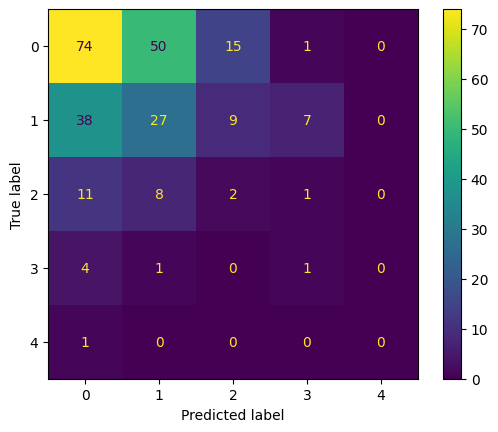

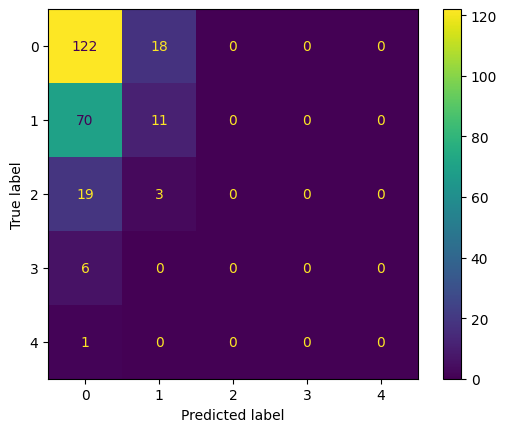

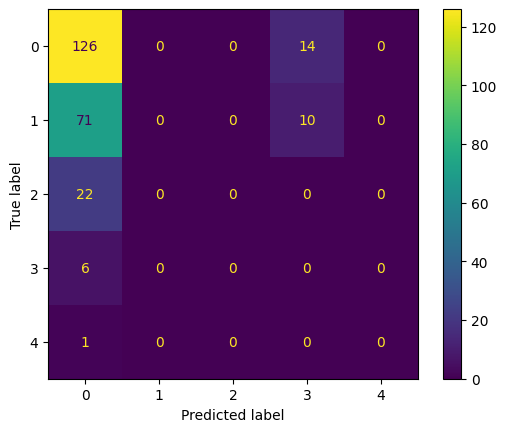

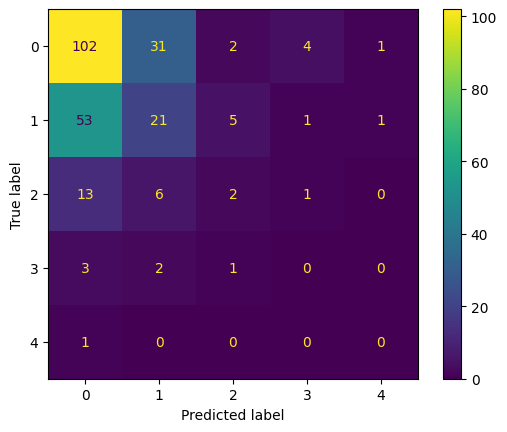

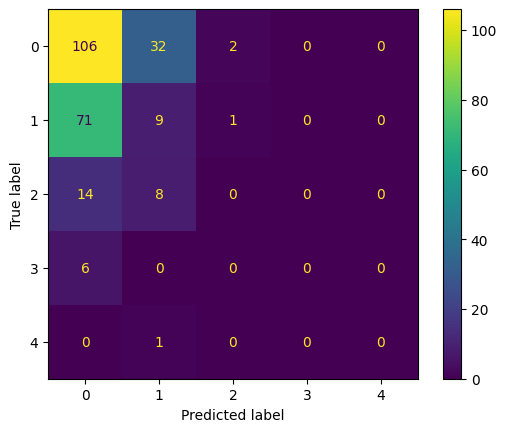

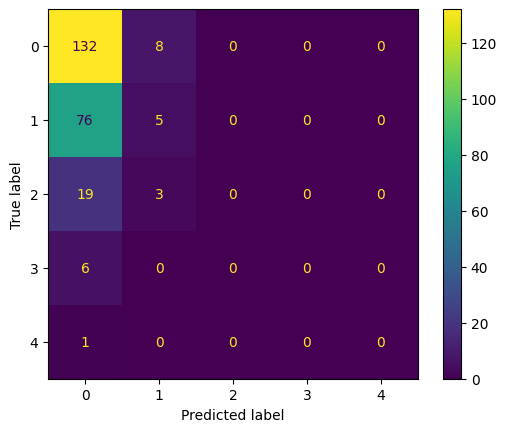

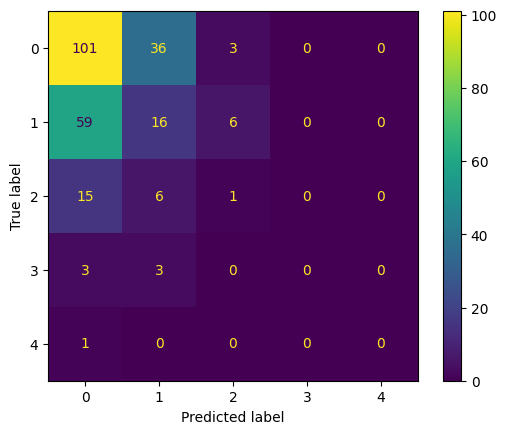

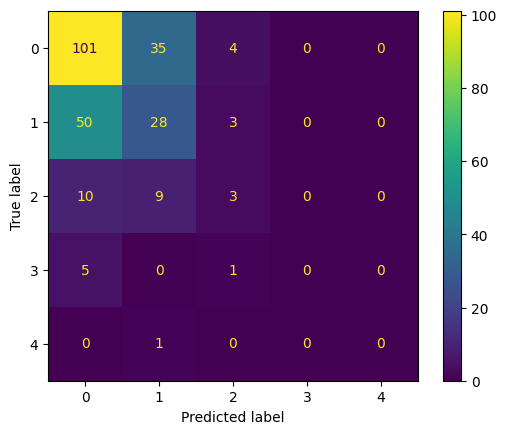

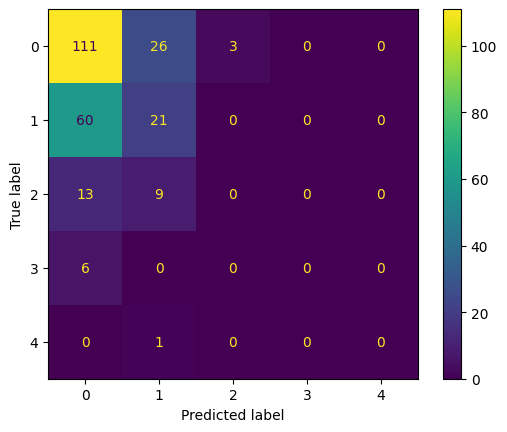

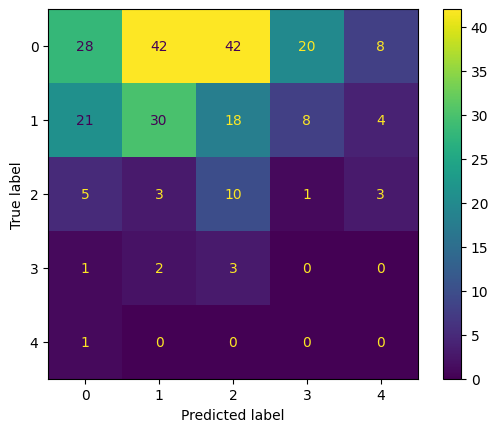

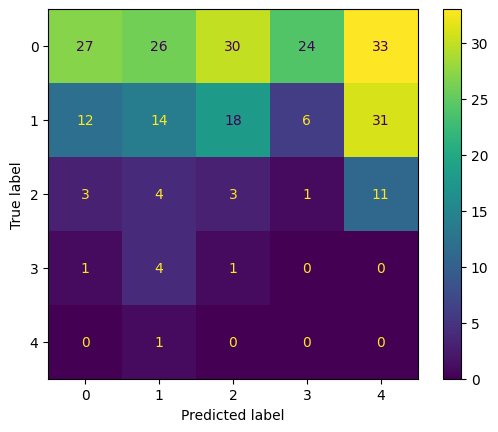

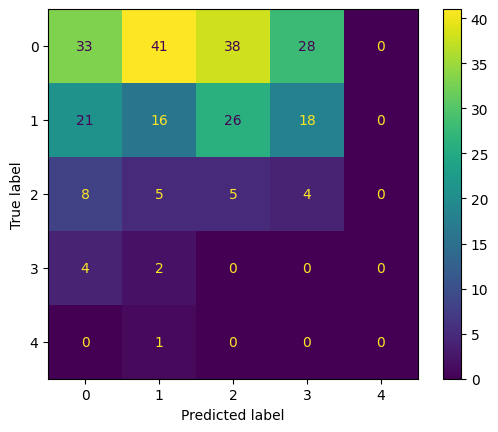

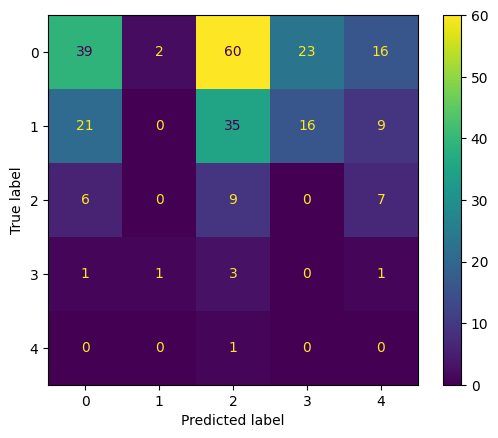

In [124]:
#test all classification models
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

models=[
tree.DecisionTreeClassifier(),
RandomForestClassifier(),
AdaBoostClassifier(),
GradientBoostingClassifier(),
LogisticRegression(),
SVC(),
KNeighborsClassifier(),
GaussianNB(),
BaggingClassifier(),
BalancedBaggingClassifier(base_estimator=tree.DecisionTreeClassifier(),sampling_strategy='auto',replacement=False,random_state=0),
BalancedRandomForestClassifier(n_estimators=100,random_state=0),
RUSBoostClassifier(),
EasyEnsembleClassifier()]

classificationResults(x_train,x_test,y_train,y_test,models)


In [ ]:
# import random parametes search
from sklearn.model_selection import RandomizedSearchCV
#random hyperparameters search for svm 
model= SVC()

param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'kernel': ['rbf', 'linear', 'poly', 'rbf', 'linear'],
                'degree':[1,2,3,4,5,6,7,8,9,10],
                'class_weight':['balanced',None],
                'decision_function_shape':['ovo','ovr']
                }
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs = -1)
random_search.fit(x_train, y_train[:,0])
print(random_search.best_params_)
print(random_search.best_score_)
print(random_search.best_estimator_)
# classificationResults(x_train,x_test,y_train,y_test,random_search.best_estimator_)




In [ ]:

# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# parameters={'n_estimators':[10,50,100,200,500],'max_depth':[5,10,20,50,100],\
#             'min_samples_split':[2,5,10,20,50],'min_samples_leaf':[1,2,5,10,20],\
#             'criterion':['gini','entropy',"log_loss"]}
# model=RandomForestClassifier()

# clf = GridSearchCV(model, parameters)
# clf.fit(x_train, y_train[:,0])

# print(clf.best_params_)
# print(clf.best_score_)


In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn import svm
# parameters={'kernel':('linear', 'poly' ,"rbf","sigmoid"),'gamma':["scale","auto"],'class_weight':[None,"balanced"]}


# model=svm.SVC()

# clf = GridSearchCV(model, parameters)
# clf.fit(x_train, y_train[:,0])

# print(clf.best_params_)
# print(clf.best_score_)


In [ ]:
# from sklearn.ensemble import AdaBoostClassifier
# model=AdaBoostClassifier()
# print(f" those are the parameters to optimize {model.get_params()}")
# parameters={"n_estimators":[10,5,20,50,100,200,500,1000],"learning_rate":[0.01,0.001,0.0001,0.05,0.1,0.2,0.5,1]}
# clf = GridSearchCV(model, parameters)
# clf.fit(x_train, y_train[:,0])

# print(clf.best_params_)
# print(clf.best_score_)


In [ ]:
#test all regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
models=[RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),\
LinearRegression(),SVR(),KNeighborsRegressor(),DecisionTreeRegressor()]
regressionResults(x_train,x_test,y_train,y_test,models)